## Goal
preprocess wav,midi into ingestible format, line up onsets

mp3 -> wav -> stft/cqt -> matrix[num_onsets][frame_size/sequence length][freq_bins]

midi -> piano_roll matrix[num_onsets][note_range] -> [Pitches vs Timestep] 2d-matrix

num_onsets = batch size?
sequence length depends on the sampling rate (most sr 16000)
bin size is frequency resolution

timestep/len_feats = 200, notes = 88 (piano)

timestep = 1/fs

input of the model: Input(shape=(len_feats, nb_notes))

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import streamlit as st
import h5py

import collections
import datetime
# import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
CONTEXT_WINDOW_ROWS = 88
HOP_LENGTH = 512
WAV_SAMPLING_RATE = 44100
CQT_SAMPLING_RATE = WAV_SAMPLING_RATE / HOP_LENGTH
# the num of samples per sec of 1 frame in the spectrogram

CQT_SLICE_RADIUS_IN_PIXELS = 2
CQT_SLICE_OFFSET_IN_PIXELS = 3
CQT_SLICE_WIDTH_IN_PIXELS = 1 + 2 * CQT_SLICE_RADIUS_IN_PIXELS


In [3]:
# data_dir = pathlib.Path('data/SMD_raw')
mid_data_dir = 'data/midi'
wav_data_dir = 'data/wav'
mid_filenames = glob.glob(str(mid_data_dir + '**/*.mid*'))
wav_filenames = glob.glob(str(wav_data_dir + '**/*.wav*')) #tk

print('Number of mid files:', len(mid_filenames))
print('Number of wav files:', len(wav_filenames))

# example use
wav_sample_file = wav_filenames[0]
print(wav_sample_file)

mid_sample_file = mid_filenames[0]
mid_sample_file2 = mid_filenames[1]

print(mid_sample_file)

Number of mid files: 50
Number of wav files: 50
data/wav/Chopin_Op028-17_005_20100611-SMD.wav
data/midi/Beethoven_Op031No2-03_002_20090916-SMD.mid


# wav

In [4]:
def lame_process(input_file, output_file):
    '''
    Converts a single MP# file to WAV format using LAME decoder
    param input_file: path to an input MP3 file
    param output_file: path to save the output WAV file
    '''
    os.system(f'lame --decode --quiet "{input_file}" "{output_file}"')


In [5]:
def convert_mp3_to_wav(input_path, output_path):
    """
    Convert all MP3 files in a directory or a single MP3 file to WAV format
    param input_path: Path to the directory containing MP3 files
    param output_path: Path to save the converted WAV files to
    """
    if os.path.isdir(input_path):
        input_files = [file for file in os.listdir(input_path) if file.lower().endswith('.mp3')]
        for file_name in input_files:
            print(f'Processing {input_path}/{file_name}')
            output_file = os.path.splitext(file_name)[0] + '.wav'
            lame_process(os.path.join(input_path, file_name), os.path.join(output_path, output_file))
    else:
        lame_process(input_path, output_path)

In [6]:
convert_mp3_to_wav('../data/SMD_raw', "../data/wav")

Can't init infile '../data/SMD_raw'


In [7]:

#base minimum frequency off of midi min freq? 
#need to iron out the inputs for the cqt 
def wav_to_spectrogram(wav_file, hop_length = 4096, fmin = 65.4, n_bins = 48, window_size = 7):
    """
    Converts a wav file into a tensor input for transformer model
    param wav: path to a wav file 
    """
    y, sr = librosa.load(wav_file)
    spectrogram = librosa.cqt(y, sr = sr, hop_length = hop_length, fmin = fmin, n_bins = n_bins) 
    
    print(spectrogram.shape) #(num_freq_bins, num_time_frames)
    spectrogram = spectrogram.T #transpose spectrogram to get right order for transformer
    spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref = np.max) #convert to dB scale 
    minDB = np.min(spectrogram)
    
    print(f'Minimum: {np.min(spectrogram)}, Maximum: {np.max(spectrogram)}, Mean: {np.mean(spectrogram)}') 
    spectrogram = np.pad(spectrogram, ((window_size//2,window_size//2),(0,0)), 'constant', constant_values=minDB)  
    print(spectrogram.shape)

    windows = []
    for i in range(spectrogram.shape[0] - window_size + 1):
        w = spectrogram[i:i + window_size, :]
        windows.append(w)
    
    x = np.array(windows)
    print(f'padded spectrogram and windowed shape: {x.shape}')

    #plot_spectrogram(spectrogram_db, sr)
    return spectrogram

In [8]:
def plot_spectrogram(spectrogram, sr):
    """
    Creates a visualization of a spectrogram, for testing purpose
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CQT Spectrogram')
    plt.tight_layout()
    plt.show()

In [9]:
def compute_cqt(y):
    """
    Computes the CQT representation of a wav file
    """
    cqt = np.abs(librosa.cqt(y, sr=SAMPLING_RATE, n_bins=CONTEXT_WINDOW_ROWS,
                           hop_length=HOP_LENGTH))
    return cqt

In [10]:
def get_all_cqts(wavPath, outputDir):
    """
    Converts a WAV file to a CQT representation and a pianoroll representation
    """
    cqt = compute_cqt(wav_sample_file)

    print("Saving CQT for " + wav_sample_file)

    tot_time = cqt.shape[1]
    radius = CQT_SLICE_RADIUS_IN_PIXELS
    offset = CQT_SLICE_OFFSET_IN_PIXELS

    onsets = np.array(range(radius, tot_time-offset-radius-1, 2*radius+1)) 
    slice_indices = np.array([(onset+offset-radius, onset+offset+radius+1) for onset in onsets])
    h5_name = os.path.join(outputDir, piece_id) + ".h5"

    with h5py.File(h5_name, "w") as hf:
        hf.create_dataset("cqt", data=cqt)
        # hf.create_dataset("onsets", data=onsets)
        # hf.create_dataset("slice_indices", data=slice_indices)

    return

# mid

In [11]:
def midi_to_piano_roll(midi_file_path, start_pitch=19, end_pitch=107, sr=CQT_SAMPLING_RATE):
    '''
    Returns an np array of the piano roll representation of a midi file, 
    with 88 notes representing those of a piano keyboard rather than 
    the default 128 notes, that is, from MIDI note 21 (A0) to MIDI note 108 (C8).
    '''
    midi_data = midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    raw_piano_roll = midi_data.get_piano_roll(fs=sr)[start_pitch:end_pitch]
    # 0 meaning not played -> converting it into binary representation
    binary_piano_roll = raw_piano_roll > 0

    print(np.shape(binary_piano_roll))
          
    return np.asarray(binary_piano_roll).astype(int)
          

# TODO: check the start and end pitch

In [12]:
def plot_piano_roll(midi_file_path, name_fig, start_pitch=19, end_pitch=107, sr=CQT_SAMPLING_RATE):
    """
    Use librosa's specshow function for displaying the piano roll (in streamlit framework)
    """

    fig = plt.figure(figsize=(10,8))
    midi_data = midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    raw_piano_roll = midi_data.get_piano_roll(fs=sr)[start_pitch:end_pitch]

    librosa.display.specshow(raw_piano_roll,
                             hop_length=1, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    plt.title(f"{name_fig}", fontsize="x-large")
    plt.xlabel("Time (s)", fontsize="x-large")
    plt.ylabel("Pitch", fontsize="x-large")
    st.pyplot(fig)


(88, 34476)
(88, 34476)


2024-04-25 00:41:48.380 
  command:

    streamlit run /Users/noracai/anaconda3/envs/csci1470/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


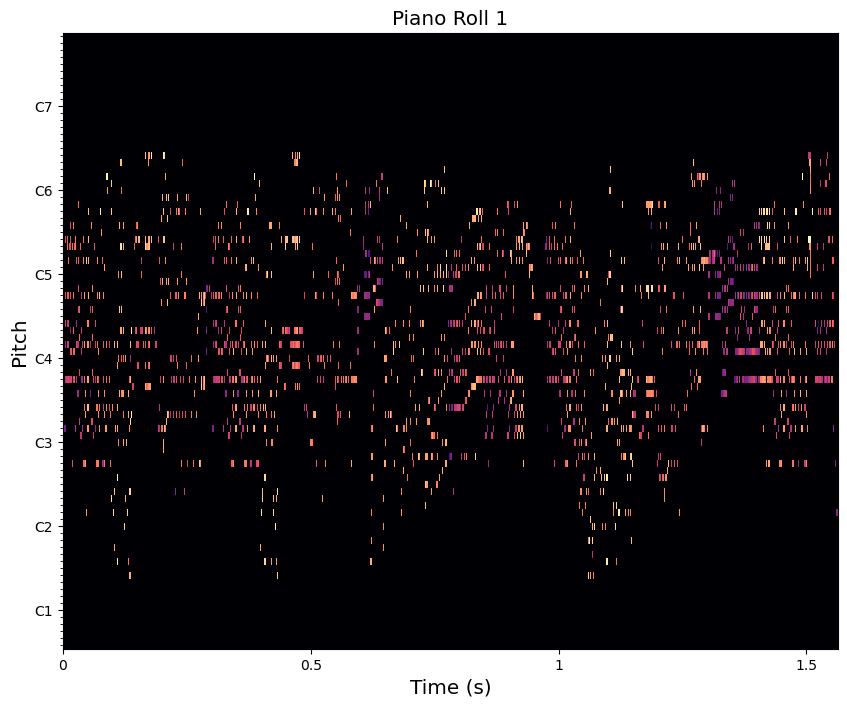

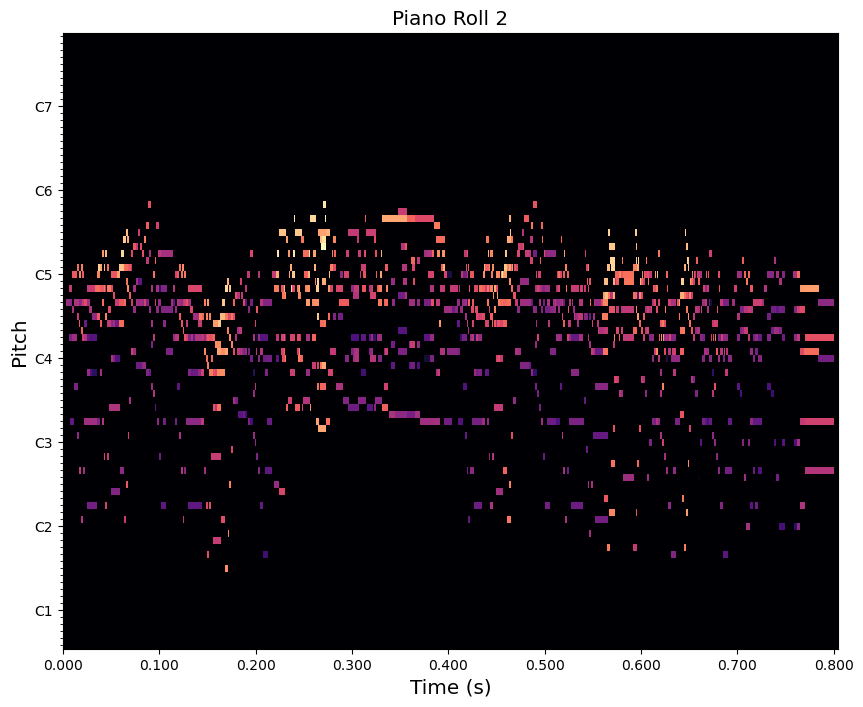

In [13]:
# Example usage
midi_file_path1 = mid_sample_file
midi_file_path2 = mid_sample_file2

midi_to_piano_roll(mid_sample_file)
midi_to_piano_roll(mid_sample_file)


plot_piano_roll(midi_file_path1, "Piano Roll 1")
plot_piano_roll(midi_file_path2, "Piano Roll 2")

In [14]:
def get_cqt_and_pianoroll(wav_path, midi_dir, output_dir):
    '''
    Converts a .wav file into CQT representation and grab the
    corresponding .midi file'''

    file_name = os.path.basename(wav_path).replace('.wav', '')
    print(file_name)
    mid_path = midi_dir + "/" + file_name + '.mid'

    if not os.path.exists(mid_path):
        print("No MIDI file found:" + mid_path)
        return
    
    print("Found CQT and pianorolls for " + file_name)
    
    # cqt = convert_wav_to_cqt(wav_path) #TODO
    piano_roll = midi_to_piano_roll(mid_path)

    print("converted CQT and pianorolls for " + file_name)

    h5_name = output_dir + file_name + ".h5"

    with h5py.File(h5_name, 'w') as hf: 

        if not os.path.exists(h5_name):
            hf.create_dataset("pianoroll", data=piano_roll)
            # hf.create_dataset("cqt", data=cqt)
        else: 
            print("h5 already existed")



In [15]:
def preprocess_wav(wav_dir, midi_dir, output_dir):
    wav_paths = glob.glob(str(wav_dir + '**/*.wav*'))  
    print('Number of wav files:', len(wav_paths))

    for wav_path in wav_paths:
        get_cqt_and_pianoroll(wav_path, midi_dir, output_dir)

preprocess_wav("data/wav", "data/midi", "data/pre_out/")

Number of wav files: 50
Chopin_Op028-17_005_20100611-SMD
Found CQT and pianorolls for Chopin_Op028-17_005_20100611-SMD
(88, 15239)
converted CQT and pianorolls for Chopin_Op028-17_005_20100611-SMD
h5 already existed
Bach_BWV871-02_002_20090916-SMD
Found CQT and pianorolls for Bach_BWV871-02_002_20090916-SMD
(88, 10766)
converted CQT and pianorolls for Bach_BWV871-02_002_20090916-SMD
h5 already existed
Rachmaninoff_Op036-01_007_20110315-SMD
Found CQT and pianorolls for Rachmaninoff_Op036-01_007_20110315-SMD
(88, 48403)
converted CQT and pianorolls for Rachmaninoff_Op036-01_007_20110315-SMD
h5 already existed
Chopin_Op029_004_20100611-SMD
Found CQT and pianorolls for Chopin_Op029_004_20100611-SMD
(88, 20927)
converted CQT and pianorolls for Chopin_Op029_004_20100611-SMD
h5 already existed
Chopin_Op010-04_007_20100611-SMD
Found CQT and pianorolls for Chopin_Op010-04_007_20100611-SMD
(88, 11293)
converted CQT and pianorolls for Chopin_Op010-04_007_20100611-SMD
h5 already existed
Ravel_Vals